# Проект модуля «Рекомендательные системы»

### Постановка задачи:

разработать рекомендательную систему для аптек. Представьте, что вы приходите на кассу, а у кассира во время формирования чека всплывает подсказка, что можно вам ещё порекомендовать.

### Библиотеки

In [104]:
#! pip install implicit
#! pip install lightfm
#! pip install annoy
#! pip install pymorphy2
#! pip install stop_words

In [1]:
import string
# Библиотека построения индекса приближенного поиска ближайших соседей
import annoy
import numpy as np
import pandas as pd
import os

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from gensim.models import FastText
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

### Функции

In [2]:
# Для фильтрации пунктуации
exclude = set(string.punctuation)
# Для приведения слов в начальной форме
morpher = MorphAnalyzer()

# Для фильтрации стоп-слов
sw = get_stop_words("ru")

def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls[1:]


### Предобработка данных

In [3]:
path = r'F:\SkillFactory\Y2_U18'

In [4]:
check_data = pd.read_csv(os.path.join(path,"чековые данные.csv"), sep=",", header=0)

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
check_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000003 entries, 0 to 20000002
Data columns (total 9 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   sale_date_date           object 
 1   contact_id               object 
 2   shop_id                  float64
 3   product_id               float64
 4   name                     object 
 5   product_sub_category_id  float64
 6   product_category_id      float64
 7   brand_id                 float64
 8   quantity                 object 
dtypes: float64(5), object(4)
memory usage: 1.3+ GB


*Поскольку датасет достаточно большой сразу убираем пропуски и дубликаты:*

In [25]:
check_data = check_data.dropna()
check_data.drop_duplicates(inplace=True)

In [26]:
check_data.head(3)

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
0,2018-12-07,1260627,1455.0,168308.0,(197312) Пакет-майка 25см х 45см,906.0,205.0,-1.0,"1,00"
1,2018-12-07,198287,279.0,134832.0,(62448) Перекись водорода р-р наружн. 3% фл.по...,404.0,93.0,-1.0,"1,00"
2,2018-12-07,2418385,848.0,101384.0,(72183) Салициловая кислота р-р спирт 2% фл 40...,404.0,93.0,-1.0,"1,00"


*Для анализа по временных характеристикам введем дополнительные свойства, производные от времени:*

In [27]:
check_data['sale_date_date'] = pd.to_datetime(check_data['sale_date_date'])
check_data['year'] = check_data.sale_date_date.dt.year.astype('int16')
check_data['month'] = check_data.sale_date_date.dt.month.astype('int8')
check_data['doy'] = check_data.sale_date_date.dt.day_of_year.astype('int16')
check_data['dow'] = check_data.sale_date_date.dt.day_of_week.astype('int8')
#check_data.drop(columns=['sale_date_date'], inplace=True)

*Для экономии ресурсов при расчетах сразу сделаем преобразование типов данных:*

In [28]:
check_data['contact_id'] = check_data['contact_id'].astype('int32')
check_data['brand_id'] = check_data['brand_id'].astype('int32')
check_data['shop_id'] = check_data['shop_id'].astype('int32')
check_data['product_id'] = check_data['product_id'].astype('int32')
check_data['product_category_id'] = check_data['product_category_id'].astype('int32')
check_data['product_sub_category_id'] = check_data['product_sub_category_id'].astype('int32')
check_data['quantity'] = check_data['quantity'].apply(lambda x: x.replace(',','.')).astype('float64')

In [31]:
check_data.drop(columns=['sale_date_date'], inplace=True)

In [32]:
check_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19703850 entries, 0 to 19999999
Data columns (total 12 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   contact_id               int32  
 1   shop_id                  int32  
 2   product_id               int32  
 3   name                     object 
 4   product_sub_category_id  int32  
 5   product_category_id      int32  
 6   brand_id                 int32  
 7   quantity                 float64
 8   year                     int16  
 9   month                    int8   
 10  doy                      int16  
 11  dow                      int8   
dtypes: float64(1), int16(2), int32(6), int8(2), object(1)
memory usage: 1014.7+ MB


In [35]:
check_data.head(3)

,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,year,month,doy,dow
0,1260627,1455,168308,(197312) Пакет-майка 25см х 45см,906,205,-1,1.0,2018,12,341,4
1,198287,279,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...,404,93,-1,1.0,2018,12,341,4
2,2418385,848,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...,404,93,-1,1.0,2018,12,341,4


### EDA

*В данном проекте анализ будет производиться поверхностно, 
лишь в целях проверки обоснования использования валидации датасета с учётом времени.
Однако в ходе исследования выяснилось в датасете наличие подкатегории продуктов product_sub_category_id = -1.
Видно, что большую часть этих данных составляет служебная информация об НДС, неустановленные названия и пакеты. По этой причине и в силу того, что датасет у нас довольно большого размера исключим из рассмотрения данную подкатегорию*

In [40]:
check_data[check_data['product_sub_category_id']==-1].name.value_counts()

(48791) Свободная сумма НДС18% (служебный)                                   147580
(110048492) название                                                          46543
(110047795) название                                                          32578
(66684) Пакет майка "Благодарим за покупку" (28+14) х 43см №1                 19094
(46045) Долгит крем 5% туба 100г N1                                           10413
                                                                              ...  
(0000122878 ) Роза Принц Жардинье                                                 1
(3479) МД Соска латексная ортодонтическая медленный поток 0+  2шт (12116)         1
(110047123) название                                                              1
(110050453) название                                                              1
(13.11.A1.900) ДНК пиогенного стрептококка (Streptococcus pyogenes)               1
Name: name, Length: 6920, dtype: int64

In [41]:
# Удаляем -1-ую подкатегорию
check_data = check_data[~((check_data['product_sub_category_id']==-1))]

In [42]:
check_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19092002 entries, 0 to 19999999
Data columns (total 12 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   contact_id               int32  
 1   shop_id                  int32  
 2   product_id               int32  
 3   name                     object 
 4   product_sub_category_id  int32  
 5   product_category_id      int32  
 6   brand_id                 int32  
 7   quantity                 float64
 8   year                     int16  
 9   month                    int8   
 10  doy                      int16  
 11  dow                      int8   
dtypes: float64(1), int16(2), int32(6), int8(2), object(1)
memory usage: 983.2+ MB


*Возможно, что заслуживают удаления подкатегории товаров 855 и 906 (91 тыс 252 тыс записей), 
но это уже должно определяться условиями бизнес-задачи. Здесь речь  идет о том, а нужно ли
учитывать при рекомендации карту клиента и упаковочные пакеты. Использования хладоэлемента многократного применения также требует отдельного анализа. На данном этапе оставляем так*

In [49]:
check_data[check_data['product_sub_category_id']==855] #906,855,-1

,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,year,month,doy,dow
12,785614,859,158662,(181542) Карта Забота о Здоровье,855,194,-1,1.0,2018,12,341,4
9923,2741182,1489,168586,(197235) Хладоэлемент многократного применения...,855,194,-1,2.0,2018,12,341,4
25167,2742486,1500,168586,(197235) Хладоэлемент многократного применения...,855,194,-1,2.0,2018,12,342,5
37369,1396182,1522,168586,(197235) Хладоэлемент многократного применения...,855,194,-1,1.0,2018,12,341,4
37393,1890069,1453,168586,(197235) Хладоэлемент многократного применения...,855,194,-1,1.0,2018,12,341,4
...,...,...,...,...,...,...,...,...,...,...,...,...
19848541,1381651,1457,168586,(197235) Хладоэлемент многократного применения...,855,194,-1,1.0,2018,6,181,5
19939225,1962295,1473,168586,(197235) Хладоэлемент многократного применения...,855,194,-1,1.0,2018,6,163,1
19969797,888385,856,158662,(181542) Карта Забота о Здоровье,855,194,-1,1.0,2018,6,163,1
19969805,891946,856,158662,(181542) Карта Забота о Здоровье,855,194,-1,1.0,2018,6,164,2


*Исследуем временные характеристики датасета. Он содержит данные только за 2018 год*

In [58]:
check_data['year'].value_counts()

2018    19092002
Name: year, dtype: int64

*Распределение данным по месяцам, говорит об их отсутвии с начала июля по октябрь включительно:*

<AxesSubplot:>

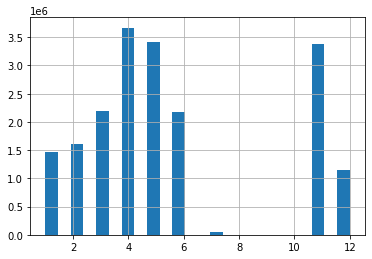

In [55]:
check_data['month'].hist(bins=24)

*Это также хорошо видно на распределении по порядковому номеру дня в году. На гистограмме хорошо заметен временной тренд на возрастание продаж по количеству позиций:*

214

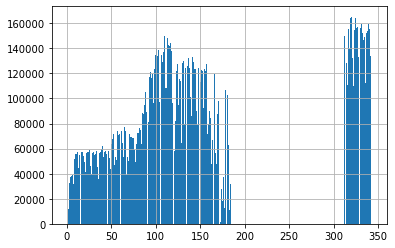

In [56]:
check_data['doy'].hist(bins=365)
check_data['doy'].nunique()

*Последнее наблюдение требует дальнейших исследований: связано ли это с увеличением количества магазинов, с появлением новых товаров, брендов или было обусловлено ростом заболеваемости в данном регионе. Последнее выходит за рамки данного исследования*

*Распределение данных по дням недели (хорошо заметно некоторое увеличение продаж в четверг и пятницу, а затем спад в субботу и воскресенье, минимальное количество продаж именно в воскресенье):*

7

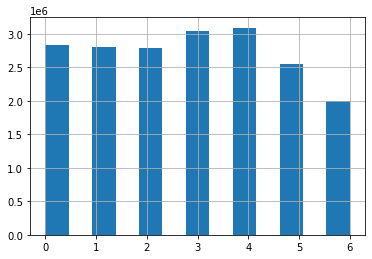

In [60]:
check_data['dow'].hist(bins = 13)
check_data['dow'].nunique()

#### Выводы о временных характеристиках датасета

*Выполненный анализ показал, что из-за отсутствия данных в датасете в течение продолжительного времени временные характеристики при делении данного датасета на валидационные части оказывать существенного значения не будут, поэтому подобное деление для данного датасета можно будет осуществлять случайным образом*

### Подготовка словаря для эмбеддингов

*Поскольку словарь, предложенный в задании содержит не все данные, необходимые нам, сформируем новый словарь самостоятельно*

*Предварительно посмотрим еще раз на распределение данных уже по наименованиям товара:*

In [62]:
check_data['name'].value_counts()

(197312) Пакет-майка 25см х 45см                                                 117367
(181542) Карта Забота о Здоровье                                                  88411
(57733) Корвалол капли д/приема внутрь 25мл                                       85714
(117825) Панангин таб.п.п.о.№50                                                   76555
(81509) PL Хлоргексидин биглюконат р-р 0.05% фл.100мл №1 (НДС 18%)                72925
                                                                                  ...  
(208161) Оправа Tempo 7546 C03                                                        1
(204858) Эфиколор Крем-краска Платиновый блондин №10 40мл                             1
(63368) Салфетки Влажные Seni Сare для ухода с вит. Е №10                             1
(112902) Натура Камчатка Гель для душа увлажняющий Цветущая Тундра 250мл туба         1
(202060) Фруктис Шампунь сос Восстановление 400мл                                     1
Name: name, Length: 29192, dtype

*Поскольку 2 первые строчки занимают пакеты и карта клиента уберем эти группы товара из датасета:*

In [63]:
# Удаляем 855, 906-ую подкатегорию
check_data = check_data[~((check_data['product_sub_category_id']==855) |\
                         (check_data['product_sub_category_id']==906))]

In [64]:
check_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18747783 entries, 1 to 19999999
Data columns (total 12 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   contact_id               int32  
 1   shop_id                  int32  
 2   product_id               int32  
 3   name                     object 
 4   product_sub_category_id  int32  
 5   product_category_id      int32  
 6   brand_id                 int32  
 7   quantity                 float64
 8   year                     int16  
 9   month                    int8   
 10  doy                      int16  
 11  dow                      int8   
dtypes: float64(1), int16(2), int32(6), int8(2), object(1)
memory usage: 965.5+ MB


*Теперь видим, что на первом месте стоит корвалол и панангин, а также уберем разовые закупки товара, попробуем избавиться от товаров, покупаемых < 10 раз на датасет*

In [65]:
check_data['name'].value_counts()

(57733) Корвалол капли д/приема внутрь 25мл                           85714
(117825) Панангин таб.п.п.о.№50                                       76555
(81509) PL Хлоргексидин биглюконат р-р 0.05% фл.100мл №1 (НДС 18%)    72925
(20116) Тауфон капли глазн 4% фл 10 мл. пласт. флак.-кап.             68046
(70458) Пенталгин таб.п.п.о.№24 (без кодеина)                         67709
                                                                      ...  
(108008) Москилл молочко от комаров д/детей Ромашка 100мл                 1
(115292) Оправа Dacchi 35141                                              1
(203763) Лабби Тарелка Русские мотивы 6+ с присоской(13652/96/12)         1
(89722) ЛОкситан Крем для тела ультрапитательный 200мл                    1
(182948) Салфетка д/очков с микрофиброй №4                                1
Name: name, Length: 29091, dtype: int64

In [74]:
a = check_data.groupby('product_id').filter(lambda g: len(g)>10).groupby('product_id').size().sort_values(ascending=False)

*Посмотрим на распределение продаж товаров по наименованиям:*

In [79]:
a

product_id
110629    85714
137539    76555
41096     72925
135427    68046
142296    67709
          ...  
195644       11
194028       11
154916       11
78664        11
161380       11
Length: 16840, dtype: int64

<AxesSubplot:>

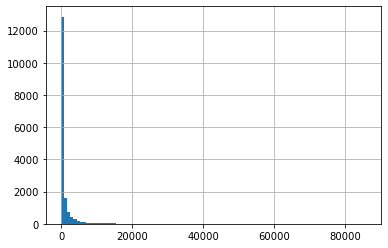

In [80]:
a.hist(bins=100)

*Оставляем в датасете только товары, участвовавшие в продажах > 10 раз*

In [81]:
check_data = check_data[check_data.product_id.isin(a.index)]

In [83]:
check_data['name'].value_counts()

(57733) Корвалол капли д/приема внутрь 25мл                                      85714
(117825) Панангин таб.п.п.о.№50                                                  76555
(81509) PL Хлоргексидин биглюконат р-р 0.05% фл.100мл №1 (НДС 18%)               72925
(20116) Тауфон капли глазн 4% фл 10 мл. пласт. флак.-кап.                        68046
(70458) Пенталгин таб.п.п.о.№24 (без кодеина)                                    67709
                                                                                 ...  
(184359) Армед Костыль опорный с УПС (FS937L) разм.М фиолетовый                     11
(116136) Мавала Скин Виталити крем дневной стимулирующий для сияния кожи 45мл       11
(120644) Сейзар таб.200мг №30                                                       11
(57409) Андрокур тб 50мг  N50                                                       11
(35347) СТИКС АльпинДерм мыло Козье молоко 100г                                     11
Name: name, Length: 16840, dtype: int64

*Формируем словарь из наименований:*

In [84]:
product = dict(zip(check_data.product_id,check_data.name))

In [ ]:
for key in product.keys():
    product[key] = preprocess_txt(product[key])

In [91]:
#Словарь Product: каждому id_продукта в соответствие поставлен предобработанный набор слов
product

{134832: ['перекись', 'водород', 'рр', 'наружн', '3', 'флполимерна', '100мл'],
 101384: ['салициловый', 'кислота', 'рр', 'спирт', '2', 'фл', '40мл', 'n1'],
 37505: ['кеппра', 'табппо500мг', '№30'],
 128700: ['ранитидина', 'тб', '150мг', 'уп', 'n20'],
 52539: ['платок', 'носовой', 'зев', 'кидс', '№10'],
 77426: ['игла', 'микрофайн', 'дшприцручка', '30g', '038мма', 'n100'],
 92475: ['дорзопт', 'капля', 'глазной', '2', '5мл', 'флкап', 'n3'],
 158643: ['pl', 'шприц', 'одноразовый', '3комп', '3мл', '№1'],
 158600: ['pl', 'шприц', 'одноразовый', '3комп', '5мл', '№1'],
 106230: ['аллапинин', 'тб', '25мг', 'n30'],
 110629: ['корвалола', 'капля', 'дприём', 'внутрь', '25мл'],
 89410: ['азафен', 'тб', '25мг', '№50'],
 106860: ['pl',
  'контейнер',
  'дбиопроба',
  'универс',
  '120мл',
  'полим',
  'крыша',
  'инд',
  'уп'],
 47251: ['pl',
  'контейнер',
  'дбиопроба',
  'стереть',
  '60мл',
  'крыша',
  'ложка',
  'индуп'],
 154704: ['метотрексатэбев', 'рр', 'ди', '10мгмл', 'шприц', '15мл', '№1'

### Контекстные рекомендации по названиям товаров в корзине

*Сформируем корзины с товарами. Корзиной будем считать каждый отдельный чек: товар группируется по дню года, номеру магазина и контакту. Соберем корзины*

In [92]:
df = check_data.groupby(['doy','shop_id','contact_id'])['product_id'].agg([set]).reset_index()

In [93]:
#f.columns = ['_'.join(col).rstrip('_') for col in df.columns.values]
df

,doy,shop_id,contact_id,set
0,1,43,17453,"{30656, 148022}"
1,1,43,28331,{54592}
2,1,43,46184,"{113585, 66818, 59862, 146135}"
3,1,43,51940,"{76308, 82045}"
4,1,43,78417,"{40243, 132911, 146135}"
...,...,...,...,...
6073295,343,1495,1793409,{64744}
6073296,343,1511,2567928,"{109489, 116291, 120163}"
6073297,343,1566,2383382,"{80777, 65805, 164014, 142296, 102814}"
6073298,343,1739,2247828,"{116387, 158645}"


In [94]:
df['goods'] = df['set'].apply(lambda x: [product[i] for i in x])

In [96]:
df['goods'] =  df['goods'].apply(lambda x: [element for sub_list in x for element in sub_list])

In [97]:
df

,doy,shop_id,contact_id,set,goods
0,1,43,17453,"{30656, 148022}","[аторис, табла, 20, мг, №90, эгилка, тб, 25мг,..."
1,1,43,28331,{54592},"[шалфей, тб, n20]"
2,1,43,46184,"{113585, 66818, 59862, 146135}","[фарингосепт, табдрассас№20, pl, аскорбинка, с..."
3,1,43,51940,"{76308, 82045}","[конкор, табппо10мг, №50, элоко, мазь, 01, туб..."
4,1,43,78417,"{40243, 132911, 146135}","[эубикор, 3гр, пак, №60, аскорбиновый, кислота..."
...,...,...,...,...,...
6073295,343,1495,1793409,{64744},"[флоксало, гл, капля, 03, фл, 5мл, №1]"
6073296,343,1511,2567928,"{109489, 116291, 120163}","[дротаверин, гидрохлорид, тб, 40мг, n50, аналь..."
6073297,343,1566,2383382,"{80777, 65805, 164014, 142296, 102814}","[микодерить, рр, днаружнприм1, флкап10мл, губк..."
6073298,343,1739,2247828,"{116387, 158645}","[тобрекс, 2х, капля, глазн, 03, фл, 5мл, n1, p..."


In [99]:
# Обучим модель fasttext на текстах
sentences = [i for i in df['goods'] if len(i) > 2]

In [100]:
modelFT = FastText(sentences=sentences, vector_size=20, min_count=1, window=5)

In [101]:
modelFT.wv.key_to_index

{'№30': 0,
 'n1': 1,
 'тб': 2,
 'фл': 3,
 'рр': 4,
 'табла': 5,
 '№20': 6,
 '№1': 7,
 '№10': 8,
 'таб': 9,
 'капс': 10,
 'капля': 11,
 'pl': 12,
 'мг': 13,
 'туба': 14,
 'мл': 15,
 '№60': 16,
 'внутрь': 17,
 'n20': 18,
 'гель': 19,
 'спреть': 20,
 'крем': 21,
 '10': 22,
 '№28': 23,
 'уп': 24,
 'n10': 25,
 '10мл': 26,
 'форт': 27,
 '№50': 28,
 '№100': 29,
 'мазь': 30,
 'амп': 31,
 'дприём': 32,
 '5мл': 33,
 'n30': 34,
 'n50': 35,
 '5': 36,
 'ппо': 37,
 'наз': 38,
 'глазн': 39,
 '100мг': 40,
 '25мл': 41,
 '40г': 42,
 'табппо': 43,
 '100мл': 44,
 '20мг': 45,
 '01': 46,
 'гр': 47,
 'х': 48,
 '1': 49,
 '50мг': 50,
 '25мг': 51,
 'таб10мг': 52,
 '30г': 53,
 '50г': 54,
 '20': 55,
 'шприц': 56,
 'сироп': 57,
 'витамин': 58,
 'ди': 59,
 '№90': 60,
 'наружн': 61,
 'конкор': 62,
 '100': 63,
 'флкап': 64,
 'кислота': 65,
 '2': 66,
 '№5': 67,
 '№14': 68,
 'одноразовый': 69,
 'бл': 70,
 'плюс': 71,
 '10мг': 72,
 '2мл': 73,
 '250мг': 74,
 'renewal': 75,
 '15г': 76,
 'драже': 77,
 '50': 78,
 'аэроза': 

In [102]:
# Для того, чтобы быстро находить айтемы положим эмбединги их тайтлов в ANN индекс
# Создадим объект индекса
ft_index_shop = annoy.AnnoyIndex(20 ,'angular')

index_map_shop = {}
counter = 0

for i in tqdm_notebook(range(len(df))):
    n_ft = 0
    index_map_shop[counter] = (df.loc[i, "goods"], df.loc[i, "set"])
    vector_ft = np.zeros(20)
    # Каждое слово обернем в эмбеддинг
    for word in df.loc[i, "goods"]:
        if word in modelFT.wv.key_to_index:
            vector_ft += modelFT.wv[word]
            n_ft += 1
    if n_ft > 0:
        vector_ft = vector_ft / n_ft
    ft_index_shop.add_item(counter, vector_ft)
    counter += 1

# 
ft_index_shop.build(10)

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/6073300 [00:00<?, ?it/s]

True

### Варианты рекомендательных систем

In [5]:
check_data = check_data.dropna()
check_data.drop_duplicates(inplace=True)
check_data['sale_date_date'] = pd.to_datetime(check_data['sale_date_date'])
#check_data['year'] = check_data.sale_date_date.dt.year.astype('int16')
#check_data['month'] = check_data.sale_date_date.dt.month.astype('int8')
check_data['doy'] = check_data.sale_date_date.dt.day_of_year.astype('int16')
#check_data['dow'] = check_data.sale_date_date.dt.day_of_week.astype('int8')
#check_data.drop(columns=['sale_date_date'], inplace=True)
check_data['contact_id'] = check_data['contact_id'].astype('int32')
check_data['brand_id'] = check_data['brand_id'].astype('int32')
check_data['shop_id'] = check_data['shop_id'].astype('int32')
check_data['product_id'] = check_data['product_id'].apply(int).apply(str)
check_data['product_category_id'] = check_data['product_category_id'].astype('int32')
check_data['product_sub_category_id'] = check_data['product_sub_category_id'].astype('int32')
check_data['quantity'] = check_data['quantity'].apply(lambda x: x.replace(',','.')).astype('float64')


In [6]:
check_data.drop(columns=['sale_date_date'], inplace=True)
# Удаляем -1-ую подкатегорию
check_data = check_data[~((check_data['product_sub_category_id']==-1))]
# Удаляем 855, 906-ую подкатегорию
check_data = check_data[~((check_data['product_sub_category_id']==855) | (check_data['product_sub_category_id']==906))]
a = check_data.groupby('product_id').filter(lambda g: len(g)>10).groupby('product_id').size().sort_values(ascending=False)
check_data = check_data[check_data.product_id.isin(a.index)]
product = dict(zip(check_data.product_id,check_data.name))

In [8]:
check_data.reset_index(inplace=True, drop=True)
check_data['order_id'] = check_data['doy'] + check_data['shop_id'] + check_data['contact_id']
check_data.sort_values('order_id', inplace=True)

In [9]:
def preprocess_(line):
    spls = "".join(i for i in str(line).strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [10]:
sentences = [preprocess_(k) for k in product.keys()]

In [11]:
sentences

[['134832'],
 ['101384'],
 ['37505'],
 ['128700'],
 ['52539'],
 ['77426'],
 ['92475'],
 ['158643'],
 ['158600'],
 ['106230'],
 ['110629'],
 ['89410'],
 ['106860'],
 ['47251'],
 ['154704'],
 ['39811'],
 ['143709'],
 ['25965'],
 ['130823'],
 ['158645'],
 ['54512'],
 ['79879'],
 ['100667'],
 ['87332'],
 ['34104'],
 ['21249'],
 ['158659'],
 ['85136'],
 ['76206'],
 ['114366'],
 ['34531'],
 ['27063'],
 ['20236'],
 ['99525'],
 ['75421'],
 ['97117'],
 ['41096'],
 ['160521'],
 ['94899'],
 ['67922'],
 ['58836'],
 ['105497'],
 ['98991'],
 ['90247'],
 ['28232'],
 ['120443'],
 ['60404'],
 ['19578'],
 ['124839'],
 ['42409'],
 ['77808'],
 ['60228'],
 ['131224'],
 ['110342'],
 ['124535'],
 ['51883'],
 ['79735'],
 ['68982'],
 ['135018'],
 ['63136'],
 ['141455'],
 ['148629'],
 ['55357'],
 ['135427'],
 ['19510'],
 ['66818'],
 ['141996'],
 ['19626'],
 ['161562'],
 ['162991'],
 ['155688'],
 ['155686'],
 ['87663'],
 ['145608'],
 ['160782'],
 ['153569'],
 ['163599'],
 ['104603'],
 ['50859'],
 ['31703'],
 ['1

In [12]:
modelFT = FastText(sentences=sentences, vector_size=20, min_count=1, window=5)
# Для того, чтобы быстро находить айтемы положим эмбединги их тайтлов в ANN индекс
# Создадим объект индекса
ft_index_names = annoy.AnnoyIndex(20 ,'angular')

# Будем хранить соответствия не только id-> фильм, но и фильм-> id, чтобы быстрее находить эмбеддинги айтемов
reverse_index_map = {}
counter = 0

for name in tqdm_notebook(product.keys()):
    n_ft = 0
    reverse_index_map[counter] = name
    vector_ft = np.zeros(20)
    # Каждое слово обернем в эмбеддинг
    for word in preprocess_(name):
        if word in modelFT.wv.key_to_index:
            vector_ft += modelFT.wv[word]
            n_ft += 1
    if n_ft > 0:
        vector_ft = vector_ft / n_ft
    ft_index_names.add_item(counter, vector_ft)
    counter += 1

# 
ft_index_names.build(10)

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/16840 [00:00<?, ?it/s]

True

In [13]:
reverse_item_mapping = {v: k for k, v in product.items()}

def recommend(items_list):
    current_vector = np.zeros(20)
    c = len(items_list)
    for iid in items_list:
        iname = product[iid]
        if iname not in reverse_index_map:
            c -= 1
            continue
        current_vector += np.array(ft_index_names.get_item_vector[reverse_index_map[iname]])
    return [product[reverse_index_map[i]] for i in ft_index_names.get_nns_by_vector(current_vector / c, 10)]

In [14]:
recommend(['95641', '125460'])

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


['(76115) Кетонал термо пластырь разогревающий №10',
 '(24025) Сенна [листья фильтр-пакеты 1.5г] N20 КЛС',
 '(16840) Нутризон смесь сухая д/энтерального питания банка 322г',
 '(114325) Эскейп таб.п.п.о.120мг №112',
 '(22032) Повязка Cosmopor E на рану самоклеящаяся стерильная 10 х 25см (900877/901023)',
 '(99791) PL Рыбий жир с экстрактом валерьяны и пустырника капс. №100',
 '(53576) Амлодипин таб.5мг №30',
 '(38953) Ферретаб комп. капс бл N30',
 '(24393) Эскузан капли оралн фл 20мл N1',
 '(44520) Бензонал тб 0.1г N50']

In [15]:
train, test = train_test_split(check_data, test_size=0.3)

In [16]:
# Обучение эмбеддингов по последовательности
from gensim.models import Word2Vec

train['product_id'] = train['product_id'].apply(int).apply(str)

grouped = train.groupby('order_id')
sentences = []

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
# Сформируем последовательности
from tqdm import tqdm_notebook
#from tqdm import tqdm 
sentences = []
for group in tqdm_notebook(grouped.groups):
    products = grouped.get_group(group)['product_id'].values
    if len(products) < 3:
        continue
    sentences.append(list(products))

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/2161149 [00:00<?, ?it/s]

In [18]:
modelW2V = Word2Vec(sentences, vector_size=20)

In [19]:
sentences[0]

['63026', '100792', '121499']

In [20]:
modelW2V.wv.similar_by_vector([1,20])

[('88183', 0.9614986181259155),
 ('132768', 0.953240156173706),
 ('85223', 0.9379034638404846),
 ('104429', 0.9205759763717651),
 ('111341', 0.9193353056907654),
 ('145313', 0.907103955745697),
 ('105497', 0.9061673879623413),
 ('45259', 0.9036638736724854),
 ('26925', 0.9003517031669617),
 ('75759', 0.8970151543617249)]

In [21]:
def recommend_w2v(items_list):
    current_vector = np.zeros(20)
    c = len(items_list)
    for iid in items_list:
        iname = product[iid]
        
        if iname not in modelW2V.wv.key_to_index:
            c -= 1
            continue
        current_vector += np.array(modelW2V.wv[reverse_index_map[iname]])
    return [product[i[0]] for i in modelW2V.wv.similar_by_vector(current_vector / c, 20)]

In [22]:
modelW2V.wv.key_to_index

{'110629': 0,
 '137539': 1,
 '41096': 2,
 '135427': 3,
 '142296': 4,
 '31212': 5,
 '156491': 6,
 '46797': 7,
 '28232': 8,
 '32834': 9,
 '97117': 10,
 '140162': 11,
 '120300': 12,
 '134832': 13,
 '158600': 14,
 '41890': 15,
 '106860': 16,
 '162780': 17,
 '104256': 18,
 '94613': 19,
 '61115': 20,
 '100907': 21,
 '48367': 22,
 '117333': 23,
 '148601': 24,
 '140683': 25,
 '81946': 26,
 '102788': 27,
 '138005': 28,
 '79960': 29,
 '149071': 30,
 '114395': 31,
 '146135': 32,
 '136478': 33,
 '104501': 34,
 '51228': 35,
 '61540': 36,
 '67609': 37,
 '42878': 38,
 '121499': 39,
 '68751': 40,
 '79724': 41,
 '146664': 42,
 '39811': 43,
 '75972': 44,
 '77238': 45,
 '129521': 46,
 '88065': 47,
 '53779': 48,
 '43027': 49,
 '153978': 50,
 '98663': 51,
 '158586': 52,
 '137039': 53,
 '95340': 54,
 '148022': 55,
 '108325': 56,
 '90353': 57,
 '113441': 58,
 '98388': 59,
 '77064': 60,
 '77808': 61,
 '88371': 62,
 '74204': 63,
 '76935': 64,
 '128984': 65,
 '63026': 66,
 '99070': 67,
 '70951': 68,
 '107409': 

In [23]:
recommend_w2v(['99821', '138583', '45321', '134475'])

C:\Users\Nata\Anaconda3\envs\meteo\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


['(112064) Биомед Прополис Зубная паста 100мл',
 '(7874) Фитосольба Фитоцитрус Шампунь д/окрашенных волос Стойкий Цвет 200мл',
 '(73059) Салфетки Хаггис Элит Софт детские влажные №128',
 '(120895) Бионик Слива сушеная пакет 80г',
 '(100477) Подгузники Либеро Ньюборн према (до 2,5кг) №24',
 '(9859) Пластырь "Omnifilm" пористый (прозрачный) 5см х 5м арт.900522\\1',
 '(119068) Виши Идеалия Лосьон-пилинг ночной фл.100мл',
 '(123506) Линза контактная Acuvue 1-DAY Moist BC=8,5 -1,25 №30',
 '(114435) Натрия хлорид р-р д/и 0.9% 5мл N10',
 '(195508) Лион Дентал Система Зубная щетка двойной эффект очищения №1',
 '(65270) Аспера Эфирное масло Мандарин 10мл',
 '(66880) Зубная щетка "Аквафреш Кидс" Мои молочные зубки для детей 3-5 лет мягкая',
 '(52312) Амитриптилин тб 25мг N50',
 '(75134) Подгузники-трусики "Merries" XL 12-22 кг №36/38',
 '(60912) КЛЕРАСИЛ Гель для умывания 150мл',
 '(107752) Дэта Бэби Комплект Инсекто (Прибор +жид. от комаров 45 ночей)',
 '(44334) Рибоксин р-р д/и 2% амп 10мл N10